# Project Outline

This project looks at the stock price of Roku. By doing a time series analysis and also a sentiment analysis on social media for the stock price of Roku we will try and predict future prices.

Project flow:
 * Gather stock price (Gathering_Data notebook)
 * Gather posts from twitter and reddit (Gathering_Data notebook)
 * Clean up and do EDA (Gathering_Data notebook)
 * Do a sentiment analysis for each day (This notebook)
 * Do a time series analysis on both stock price and sentiment individually (This notebook)
 * Combine the sentiment and stock price to try and predict future prices (This notebook)

# Importing packages and loading data

In [58]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twint
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import datetime as dt
import time
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/Users/stevenkyle/opt/anaconda3/envs/Capstone/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Loading data
T_df = pd.read_csv('TwitterData.csv', header=None)
T_df.columns = ['id', 'date', 'timezone', 'tweet', 'language', 'cashtags', 
                'username', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets', 'search']
R_df = pd.read_csv('redditdata.csv')
S_df = pd.read_csv('StockData.csv')

# Functions

In [3]:
# This function will remove emojis from the text

def RemoveEmojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
# This function is to run text through spacy/textblob pipeline
def Sentiment(text):
    
    #Initializing Sentiment analyzer
    SIA = SentimentIntensityAnalyzer()
    
    # Words to add to the sentiment lexicon
    new_words = {
        'bullish': 3.4,
        'bull':3.4,
        'long':3.4,
        'longs':3.4,
        'Holding':3.4,
        'holding':3.4,
        'Hodl':3.4,
        'hodl':3.4,
        'Call':3.4,
        'Calls':3.4,
        'call':3.4,
        'calls':3.4,
        'Put':-3.9,
        'Puts':-3.9,
        'put':-3.9,
        'puts':-3.9,
        'bear':-3.9,
        'bearish':-3.9,
        'short': -3.9,
        'shorts':-3.9
        }

    # Updating lexicon
    SIA.lexicon.update(new_words)
    
    # Running
    output = SIA.polarity_scores(text)
    
    return output['compound']

# Clean up and EDA

## Clean up Twitter EDA

In [5]:
print(T_df.shape)
T_df.head()

(666, 13)


,id,date,timezone,tweet,language,cashtags,username,day,hour,nlikes,nreplies,nretweets,search
0,913765506456473600,2017-09-29 09:00:48,-500,"$1900 in 10 minutes on $ROKU, so glad the mark...",en,['roku'],eatsleepprofit,5,9,69,8,2,$ROKU
1,913841066473869313,2017-09-29 14:01:03,-500,$ROKU is already up almost 100% since its IPO....,en,['roku'],Stocktwits,5,14,40,5,23,$ROKU
2,914147418316398592,2017-09-30 10:18:23,-500,Mystified by $ROKU's IPO? @JimCramer's breakin...,en,['roku'],MadMoneyOnCNBC,6,10,29,5,11,$ROKU
3,913892627845570560,2017-09-29 17:25:56,-500,"$ROKU Long. One Ticker, a few trades. Couldve ...",en,['roku'],SmashTheBid,5,17,28,4,0,$ROKU
4,913843670872444928,2017-09-29 14:11:24,-500,Love #Pennystocks Nice Friday for my 2 account...,en,"['vcel', 'izea', 'gluu', 'roku']",EbogeyEd,5,14,24,1,3,$ROKU


In [6]:
# Making date in dataframe just the date and no time
T_df['date'] = T_df.date.apply(lambda x: x.split(' ',1)[0])

# Dropping any scraped entries that aren't english
T_df.drop(T_df[T_df['language'] != 'en'].index, inplace = True)

# Only keeping date and tweet
T_df = T_df[['date','tweet']]

In [7]:
# Removing any url links
T_df['tweet_LinkRemoved'] = T_df.tweet.apply(
    lambda x: re.sub(r'https\S+', '', x))

# Removing any emojis
T_df['tweet_Link+Emoji_Removed'] = T_df.tweet_LinkRemoved.apply(
    lambda x: RemoveEmojis(x))

# Change things to lower case
T_df['tweet_cleaned_lowercase'] = T_df['tweet_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
T_df['tweet_cleaned_lower_NoPunct'] = T_df['tweet_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
T_df['tweet_FinalClean'] = T_df['tweet_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

## Clean up Reddit

In [8]:
R_df.head()

,ID,Num_Comments,Score,Subreddit,Title,Upvote_Ratio,Created,Created_utc,Self_text,Date
0,730n8l,50,113,investing,ROKU up 28% shortly after IPO,0.91,1.506640e+09,1.506611e+09,http://www.hollywoodreporter.com/news/roku-sto...,2017-09-28
1,72ztnr,0,35,stocks,9/28 Thursday Stock Market Movers & News,0.89,1.506631e+09,1.506603e+09,#Good morning traders of the r/stocks sub! Hap...,2017-09-28
2,730zps,31,26,wallstreetbets,WHEN TO SHORT ROKU,0.85,1.506643e+09,1.506614e+09,"this company does nothing new, i think 24~ SHO...",2017-09-28
3,7314h8,37,20,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,0.95,1.506644e+09,1.506615e+09,NaN,2017-09-28
4,730jwz,33,14,wallstreetbets,"$ROKU IPO, to the moon...?",0.90,1.506639e+09,1.506610e+09,Why isn't this thing available on my POS broke...,2017-09-28


In [9]:
# The things we care about are date, subreddit, title, and self_text
R_df = R_df[['Date','Subreddit','Title','Self_text']]

# Combining the title and self text
R_df['Self_text'] = R_df['Self_text'].fillna('.')
R_df['Combined_text'] = R_df['Title'] + ' ' + R_df['Self_text']

In [10]:
# Removing any links
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text.apply(
    lambda x: re.sub(r'https\S+', '', x))
R_df['Combined_text_LinksRemoved'] = R_df.Combined_text_LinksRemoved.apply(
    lambda x: re.sub(r'http\S+', '', x))

# Removing any emojis
R_df['Combined_text_Link+Emoji_Removed'] = R_df.Combined_text_LinksRemoved.apply(lambda x: RemoveEmojis(x))

# Change things to lower case
R_df['Combined_text_cleaned_lowercase'] = R_df['Combined_text_Link+Emoji_Removed'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuations
R_df['Combined_text_cleaned_lower_NoPunct'] = R_df['Combined_text_cleaned_lowercase'].str.replace(
    '[^\w\s]', '')

# Remove stopwards
stop = stopwords.words('english')
R_df['Combined_text_FinalClean'] = R_df['Combined_text_cleaned_lower_NoPunct'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))

In [11]:
R_df

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers
...,...,...,...,...,...,...,...,...,...,...
613,2021-05-11,wallstreetbets,"$FUBO - Archegos, Misreported Earnings, and th...",Reporting AH ( 45 mins ) so i dont have much t...,"$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$FUBO - Archegos, Misreported Earnings, and th...","$fubo - archegos, misreported earnings, and th...",fubo archegos misreported earnings and the qu...,fubo archegos misreported earnings quiet perio...
614,2021-05-12,investing,Best Dip Stocks to buy right now,"Hey y'all,\n\nI have alot of cash lying around...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","Best Dip Stocks to buy right now Hey y'all,\n\...","best dip stocks to buy right now hey y'all, i ...",best dip stocks to buy right now hey yall i ha...,best dip stocks buy right hey yall alot cash l...
615,2021-05-13,Daytrading,"The Only Watch List You Need May 13, 2021",*The original Gap Watch List Poster! The one t...,"The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","The Only Watch List You Need May 13, 2021 *The...","the only watch list you need may 13, 2021 *the...",the only watch list you need may 13 2021 the o...,watch list need may 13 2021 original gap watch...
616,2021-05-20,wallstreetbets,PUBM DD #1,\n\nA little bit about myself for context:\n\...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,PUBM DD #1 \n\nA little bit about myself for ...,pubm dd #1 a little bit about myself for conte...,pubm dd 1 a little bit about myself for contex...,pubm dd 1 little bit context 1 work enterprise...


In [12]:
R_df.iloc[0]['Combined_text_LinksRemoved']

'ROKU up 28% shortly after IPO \n\n>The video streaming device maker had late Wednesday set its initial public offering price at $14 per share, or a market value of $1.3 billion.\n\n>The stock of video streaming device maker Roku rose in its stock market debut on Thursday. It opened just after 10:35 a.m. ET at $15.78, up 12.7 percent.\n\n>About 10 minutes later, it was up 28 percent at $17.94.\n\n>The company had recently filed for an initial public offering and late Wednesday had set its IPO price at $14 per share, which raised about $219 million and made for a market value of $1.3 billion.\n\n>The  Los Gatos, Calif.-based company, which makes TV set-top boxes and other devices, listed its stock on the Nasdaq under the ticker symbol ROKU. Its filing have shown that Roku lost $42.8 million in 2016 on nearly $399 million in revenue, up 25 percent from 2015.\n\n>Roku, led by CEO Anthony Wood, has also disclosed that its users streamed more than 6.7 billion hours of programming on its pla

# Exploring sentiment analysis, Vader

In [13]:
# Figuring out the max and min of the scores in the lexicon
SIA = SentimentIntensityAnalyzer()

maxi = 0
mini = 0

for k,v in SIA.lexicon.items():

    if v > maxi:
        maxi = v
    if v < mini:
        mini = v
        
print('Maximum points for a word/emoticon', maxi)
print('Minimum points for a word/emoticon', mini)

Maximum points for a word/emoticon 3.4
Minimum points for a word/emoticon -3.9


Added custom words with scores as either the maximum or minimum in the Sentiment Function located earlier in the notebook. Vader can take in emoji's, going to try a tweet examples with an emoji and without the emojis to see which one is more accurate.

In [14]:
# Tweet with the links removed
T_df.iloc[0]['tweet_LinkRemoved']

"$1900 in 10 minutes on $ROKU, so glad the market is picking up with multiple runners literally everyday. I really hope this doesn't stop🙏🏼😁  "

In [15]:
print('Score with the emoji: ',Sentiment(T_df.iloc[0]['tweet_LinkRemoved']))
print('Score without the emoji: ',Sentiment(T_df.iloc[0]['tweet_Link+Emoji_Removed']))

Score with the emoji:  0.8989
Score without the emoji:  0.838


It looks like the tweet with the emoji is more accurate, for future sentiment analysis the emoji's will be used in the text.

# Combining Reddit and Twitter Data

In [16]:
T_df.head()

,date,tweet,tweet_LinkRemoved,tweet_Link+Emoji_Removed,tweet_cleaned_lowercase,tweet_cleaned_lower_NoPunct,tweet_FinalClean
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $ROKU, so glad the mark...","$1900 in 10 minutes on $roku, so glad the mark...",1900 in 10 minutes on roku so glad the market ...,1900 10 minutes roku glad market picking multi...
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$ROKU is already up almost 100% since its IPO....,$roku is already up almost 100% since its ipo....,roku is already up almost 100 since its ipo he...,roku already almost 100 since ipo heres went p...
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,Mystified by $ROKU's IPO? @JimCramer's breakin...,mystified by $roku's ipo? @jimcramer's breakin...,mystified by rokus ipo jimcramers breaking it ...,mystified rokus ipo jimcramers breaking
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$ROKU Long. One Ticker, a few trades. Couldve ...","$roku long. one ticker, a few trades. couldve ...",roku long one ticker a few trades couldve done...,roku long one ticker trades couldve done lot b...
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,Love #Pennystocks Nice Friday for my 2 account...,love #pennystocks nice friday for my 2 account...,love pennystocks nice friday for my 2 accounts...,love pennystocks nice friday 2 accounts 1200 v...


In [17]:
R_df.head()

,Date,Subreddit,Title,Self_text,Combined_text,Combined_text_LinksRemoved,Combined_text_Link+Emoji_Removed,Combined_text_cleaned_lowercase,Combined_text_cleaned_lower_NoPunct,Combined_text_FinalClean
0,2017-09-28,investing,ROKU up 28% shortly after IPO,http://www.hollywoodreporter.com/news/roku-sto...,ROKU up 28% shortly after IPO http://www.holly...,ROKU up 28% shortly after IPO \n\n>The video s...,ROKU up 28% shortly after IPO \n\n>The video s...,roku up 28% shortly after ipo >the video strea...,roku up 28 shortly after ipo the video streami...,roku 28 shortly ipo video streaming device mak...
1,2017-09-28,stocks,9/28 Thursday Stock Market Movers & News,#Good morning traders of the r/stocks sub! Hap...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 Thursday Stock Market Movers & News #Good...,9/28 thursday stock market movers & news #good...,928 thursday stock market movers news good mo...,928 thursday stock market movers news good mor...
2,2017-09-28,wallstreetbets,WHEN TO SHORT ROKU,"this company does nothing new, i think 24~ SHO...",WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,WHEN TO SHORT ROKU this company does nothing n...,when to short roku this company does nothing n...,when to short roku this company does nothing n...,short roku company nothing new think 24 short ...
3,2017-09-28,wallstreetbets,ROKU now listex on NASDAQ. Up 35% so far,.,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,ROKU now listex on NASDAQ. Up 35% so far .,roku now listex on nasdaq. up 35% so far .,roku now listex on nasdaq up 35 so far,roku listex nasdaq 35 far
4,2017-09-28,wallstreetbets,"$ROKU IPO, to the moon...?",Why isn't this thing available on my POS broke...,"$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$ROKU IPO, to the moon...? Why isn't this thin...","$roku ipo, to the moon...? why isn't this thin...",roku ipo to the moon why isnt this thing avail...,roku ipo moon isnt thing available pos brokers


In [18]:
# Combining the Twitter dataframe and the Reddit Dataframe
temp_T_df = T_df[['date','tweet_LinkRemoved']].copy()
temp_T_df.columns = ['Date','Text']

temp_R_df = R_df[['Date','Combined_text_LinksRemoved']].copy()
temp_R_df.columns = ['Date','Text']

Sentiment_df = pd.concat([temp_T_df,temp_R_df])

In [19]:
print('Check to see if combination worked.')
print('Twitter dataframe number of entries: ', len(T_df))
print('Reddit dataframe number of entries: ', len(R_df))
print('Combined dataframe number of entries: ', len(Sentiment_df))

Check to see if combination worked.
Twitter dataframe number of entries:  565
Reddit dataframe number of entries:  618
Combined dataframe number of entries:  1183


# Running the sentiment function to find sentiment scores

In [20]:
Sentiment_df['Score'] = Sentiment_df.Text.apply(lambda x: Sentiment(x))

In [21]:
Sentiment_df

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222
...,...,...,...
613,2021-05-11,"$FUBO - Archegos, Misreported Earnings, and th...",0.8991
614,2021-05-12,"Best Dip Stocks to buy right now Hey y'all,\n\...",0.9050
615,2021-05-13,"The Only Watch List You Need May 13, 2021 *The...",0.9868
616,2021-05-20,PUBM DD #1 \n\nA little bit about myself for ...,0.9992


In [22]:
Text_to_check = Sentiment_df[Sentiment_df['Score'] == 0]
Text_to_check

,Date,Text,Score
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0
15,2017-12-08,$ROKU Next week there will be a big storm in S...,0.0
23,2017-12-22,First time since after $ROKU earnings in Nov n...,0.0
24,2017-12-30,"Oh, what a year. 📈 #BestOf2017 stocks from IB...",0.0
...,...,...,...
478,2020-12-01,$ROKU I can’t quit you .,0.0
502,2020-12-24,"Finally upgraded to the next leve(nio, Roku, e...",0.0
512,2021-01-05,Quibi Selling Catalog To Roku: Report .,0.0
531,2021-01-20,$NFLX $DIS $ROKU Streaming Services Comparison...,0.0


In [23]:
print('Texts from ',len(Text_to_check),' had a sentiment score of 0 (they analyzer did not understand or they were neutral).')
print('That is ', len(Text_to_check)/len(Sentiment_df)*100,'% of the entries we have.')

Texts from  173  had a sentiment score of 0 (they analyzer did not understand or they were neutral).
That is  14.623837700760777 % of the entries we have.


# Combining the scores for each day and combining all data to one dataframe

In [24]:
Sentiment_df.head()

,Date,Text,Score
0,2017-09-29,"$1900 in 10 minutes on $ROKU, so glad the mark...",0.8989
1,2017-09-29,$ROKU is already up almost 100% since its IPO....,0.0000
2,2017-09-30,Mystified by $ROKU's IPO? @JimCramer's breakin...,0.0000
3,2017-09-29,"$ROKU Long. One Ticker, a few trades. Couldve ...",0.5647
4,2017-09-29,Love #Pennystocks Nice Friday for my 2 account...,0.9222


In [26]:
Avg_Sentiment_df = Sentiment_df.groupby(['Date']).mean()

In [27]:
Avg_Sentiment_df.head()

,Score
Date,
2017-09-28,0.185700
2017-09-29,0.457833
2017-09-30,0.000000
2017-10-02,-0.094050
2017-10-05,-0.011300


In [29]:
len(Avg_Sentiment_df)

519

In [30]:
len(S_df)

923

In [32]:
S_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-28,15.800000,23.500000,15.750000,23.500000,23.500000,39265900
1,2017-09-29,26.740000,29.799999,25.469999,26.540001,26.540001,44294700
2,2017-10-02,25.200001,26.280001,23.260000,23.559999,23.559999,16008400
3,2017-10-03,23.010000,23.020000,20.770000,20.809999,20.809999,13678500
4,2017-10-04,21.290001,22.600000,20.820000,20.850000,20.850000,9345700


In [33]:
S_df_closing = S_df[['Date','Close']]
S_df_closing.head()

,Date,Close
0,2017-09-28,23.500000
1,2017-09-29,26.540001
2,2017-10-02,23.559999
3,2017-10-03,20.809999
4,2017-10-04,20.850000


In [77]:
Final_df = pd.merge(left=S_df_closing, right=Avg_Sentiment_df, how='left', left_on='Date', right_on='Date')
Final_df.columns = ['Date','Close','Sentiment_Score']
Final_df['Date'] = pd.to_datetime(Final_df['Date'])
Final_df.set_index('Date', inplace=True)
Final_df = Final_df.asfreq('B', method='ffill')
Final_df

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
...,...,...
2021-05-24,347.220001,NaN
2021-05-25,345.700012,0.986600
2021-05-26,348.989990,NaN


In [78]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2017-09-28 to 2021-05-28
Freq: B
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            957 non-null    float64
 1   Sentiment_Score  449 non-null    float64
dtypes: float64(2)
memory usage: 22.4 KB


In [79]:
Final_df.Close.isna().sum()

0

In [80]:
Final_df.head(75)

,Close,Sentiment_Score
Date,,
2017-09-28,23.500000,0.185700
2017-09-29,26.540001,0.457833
2017-10-02,23.559999,-0.094050
2017-10-03,20.809999,NaN
2017-10-04,20.850000,NaN
2017-10-05,22.010000,-0.011300
2017-10-06,23.200001,NaN
2017-10-09,24.540001,-0.938800
2017-10-10,22.930000,0.000000


Going to fill missing sentiment data by taking a gradient from last known sentiment to the next known sentiment.

In [81]:
Final_df['Sentiment_Score_LinearFill'] = Final_df['Sentiment_Score'].interpolate(method='linear')

In [83]:
Final_df.tail(5)

,Close,Sentiment_Score,Sentiment_Score_LinearFill
Date,,,
2021-05-24,347.220001,NaN,0.624075
2021-05-25,345.700012,0.9866,0.986600
2021-05-26,348.989990,NaN,0.789500
2021-05-27,349.029999,NaN,0.592400
2021-05-28,346.709991,0.3953,0.395300


# Time series analysis for Stock Data

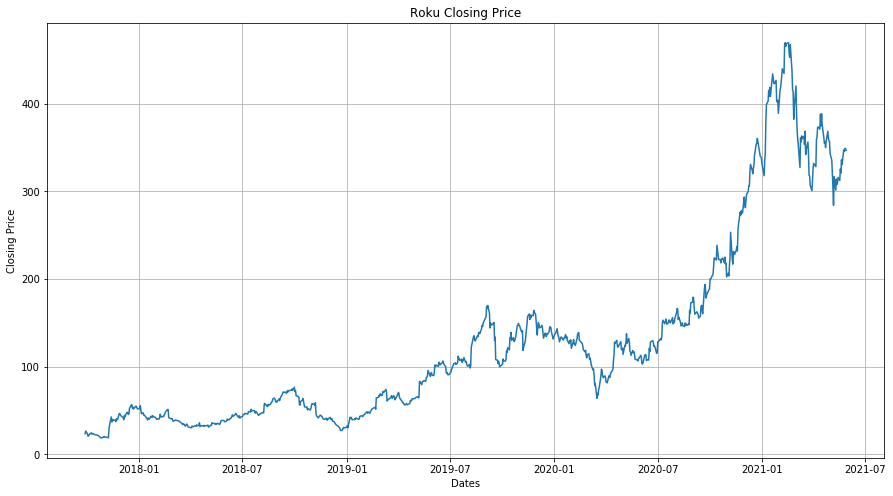

In [57]:
plt.figure(figsize = (15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(Final_df['Close'])
plt.title('Roku Closing Price')
plt.show()

In [87]:
# Train Test Split (Making testing data the last 2 months)
Train, Test = train_test_split(Final_df, test_size=42)

In [89]:
Train.tail()

,Close,Sentiment_Score,Sentiment_Score_LinearFill
Date,,,
2021-03-25,317.619995,NaN,-0.036180
2021-03-26,306.820007,-0.01640,-0.016400
2021-03-29,300.790009,NaN,0.479625
2021-03-30,311.959991,0.97565,0.975650
2021-03-31,325.769989,0.25520,0.255200


In [90]:
print('Train set has', len(Train),'entries.')
print('Test set has', len(Test),'entries.')

Train set has 915 entries.
Test set has 42 entries.


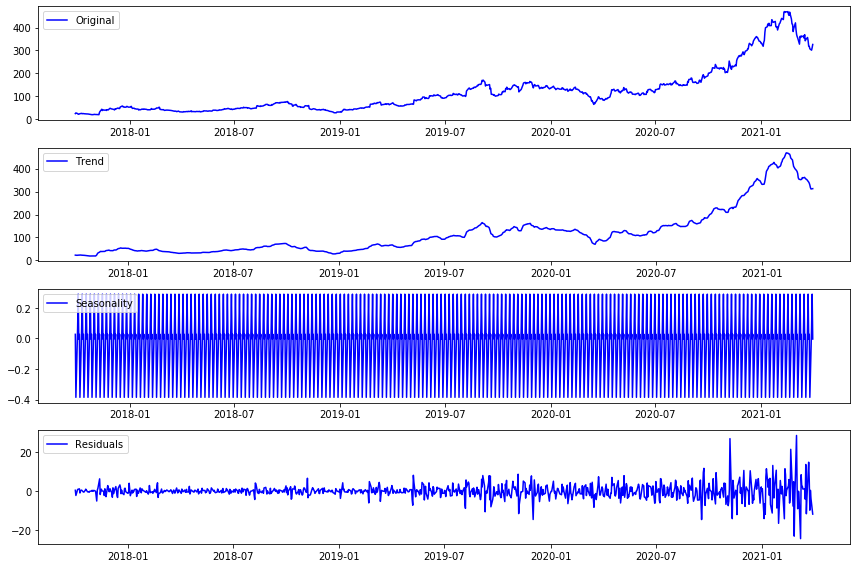

In [92]:
# Taking the decomposition of Roku Stock
decomposition = seasonal_decompose(Train['Close'])

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Train['Close'], label='Original', color='blue')
plt.legend(loc='best')

# Plotting the Trend of the data
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plotting the Seasonality of the data
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

# Plotting the Residuals of the data
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()